<a href="https://colab.research.google.com/github/connor-verheyen/DataDrivenGranularHydrogels/blob/main/analysis/Model_Predicting_Rheo_SingleOutput_OscYieldStress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import basic libraries 
import os 
import pandas as pd 
import numpy as np 
import scipy as sp 
import math
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy import stats
from scipy.optimize import curve_fit

In [ ]:
# Read the excel sheets into a multi-index dataframe 

file_name = 'https://github.com/connor-verheyen/DataDrivenGranularHydrogels/blob/main/data/Dataset_CompilingAllRheology.xlsx?raw=true'

sheet_list = ['Stress', 'Strain', 'Freq', 'Flow']

level_0 = []
for sheet in sheet_list: 

  df = pd.read_excel(file_name,sheet_name=sheet,header=0)

  level_0.append(df)

test = pd.concat(level_0,keys=sheet_list).drop(columns={'Unnamed: 0'})

In [ ]:
# Generate a unique string identifier composed of the filename, tabname, concentration, and volume fraction
test['String ID'] = [str(filename) + '_' + str(tabname) + '_' + str(testname) + '_' + str(conc) + '_' + str(vf) for filename, tabname, testname, conc, vf in zip(test['FileName'],test['TabName'],test['TestName'],test['Microgel Conc. (%)'],test['Est. Volume Fraction'])]

# Assign a unique numerical ID to each string identifier 
test['Unique ID'] = pd.factorize(test['String ID'])[0]

In [ ]:
# Iteratively drop all of the datapoints where the stress values start going backwards (erroneous datapoints that the rheometer captured once the material had already yielded)

while test.groupby('Unique ID')['Oscillation stress (Pa)'].diff().fillna(0).ge(0).eq(0).sum() >0:

  #print(test.groupby('Unique ID')['Oscillation stress (Pa)'].diff().fillna(0).ge(0).eq(0).sum()) # To monitor the progress of the data cleaning

  test = test[test.groupby('Unique ID')['Oscillation stress (Pa)'].diff().fillna(0).ge(0)] 

In [ ]:
# Drop any observations where the storage modulus is negative
test.drop(test[test['Storage modulus (Pa)'].lt(0)].index,inplace=True)

# Drop any observations where the loss modulus is negative
test.drop(test[test['Loss modulus (Pa)'].lt(0)].index,inplace=True)

# Drop any observations where the tangent delta is negative
test.drop(test[test['Tan(delta)'].lt(0)].index,inplace=True)

# Drop the initial values on the forward flow curves that don't make sense (viscosity at the initial value is lower than the next value even though shear rate is increasing and viscosity should be dropping)
test.drop(index=test[(test['TestName']=='Flow Curve') & test['Shear rate (1/s)'].le(1e-2)].index,inplace=True)

# Replace the testname for the reverse flow curves so everything matches
test['TestName'].replace(to_replace='Reverse Flow Curve',value='Rev Flow Curve',inplace=True)

In [ ]:
resuspension = {'Single Wash': 1,
                 'Multi Wash': 2,}
test['Resuspension_encoded'] = test['Resuspension Details'].map(resuspension) # Ordinal categorical 

In [ ]:
#%%capture 

rheo_analysis_list = []

for i in test['Unique ID'].unique(): # Go through each of the unique trials in the dataset 

  data_to_fit = test[test['Unique ID']==i] # Grab a single trial from the dataset based on the unique ID

  trial_details = pd.concat([data_to_fit.iloc[:1,:15], data_to_fit.iloc[:1,-2:]],axis=1) # Store all of the trial details so you can add it to a new dataframe

  if data_to_fit['TestName'].iloc[0] != 'Flow Curve' and data_to_fit['TestName'].iloc[0] != 'Rev Flow Curve' and data_to_fit['TestName'].iloc[0] != 'Freq Sweep': # Check if it's on osc stress or strain amplitude sweep 

    #### FIT THE LINEAR PLATEAU VALUES
    if data_to_fit.iloc[0,:]['Storage modulus (Pa)'] > 1e3: # Define the plateau region -> longer plateau for the stiffer particles, shorter plateau for the softer particles (they yield at lower stress values)
      plateau_region = data_to_fit[data_to_fit['Oscillation stress (Pa)']<1e1]
    elif data_to_fit.iloc[0,:]['Storage modulus (Pa)'] > 1e2:
      plateau_region = data_to_fit[data_to_fit['Oscillation stress (Pa)']<2e0]
    else: 
      plateau_region = data_to_fit[data_to_fit['Oscillation stress (Pa)']<5e-1]

    x = plateau_region['Oscillation stress (Pa)'] # Define the x values to be used for the fitting process 
    
    y_names = ['Storage modulus (Pa)', 'Loss modulus (Pa)', 'Complex modulus (Pa)', 'Tan(delta)'];   y_fitted_names = ['Storage_0','Loss_0','Complex_0','Tand_0']

    for j in range(len(y_names)): # Go through each of the the limiting plateau values you want to fit (in the LVR)
      
      y = plateau_region[y_names[j]] # Define the y values to be used for the fitting process 
      
      mask = ~np.isnan(y); y = y[mask]; x = x[mask] # Make a mask and then drop any values that are NaN because they won't work for fitting 
      
      intercept = stats.linregress(x,y).intercept # Perform a linear fitting of the plateau region for the given y value 
      
      trial_details[y_fitted_names[j]] = intercept # Store the fitted y value with the corresponding trial details 
    
    #### FIND THE YIELD STRESS USING THE G' BREAKDOWN METHOD 
    breakdown_pct = [10,33,50]; # Define different storage modulus breakdown values (Method #1 for determining yield stress -> look for the region where the storage modulus shows significant deviation from the linear plateau value)

    for k in range(len(breakdown_pct)):

      modulus_threshold = trial_details['Storage_0'].values[0]*(1-breakdown_pct[k]/100) # Convert the percentage and then multiply by the plateau storage modulus to get the breakdown threshold
      try:

        iloc=0; ys=False;
        while ys == False:

          # Compare the current storage modulus datapoint to the mean of the following three datapoints
          if data_to_fit['Storage modulus (Pa)'].iloc[iloc] > data_to_fit['Storage modulus (Pa)'].iloc[iloc+1:iloc+4].mean(): 

            # Compare the current storage modulus datapoint to the breakdown threshold 
            if data_to_fit['Storage modulus (Pa)'].iloc[iloc] < modulus_threshold: 

              # If both of the above conditions are satisfied, you have your yield point -> define and save the yield stress and yield strain in the dataframe 

              trial_details['YS_breakdown_'+str(breakdown_pct[k])] = data_to_fit['Oscillation stress (Pa)'].iloc[iloc]
              trial_details['YStrain_breakdown_'+str(breakdown_pct[k])] = data_to_fit['Oscillation strain (%) '].iloc[iloc]
              
              ys=True # To exit the while loop
          
          iloc+=1 # To increment the indexer while searching for the yield stress 

      except: 
        #print('failed',i)
        pass 

  rheo_analysis_list.append(trial_details)

# Compile all of the analyzed data into a single dataframe 
rheo_analysis = pd.concat(rheo_analysis_list).reset_index(drop=True)

# Merge results with the original dataframe as well so you can color by fitted values
test2 = pd.merge(left=test,right=rheo_analysis.iloc[:,5:],on='Unique ID')

In [ ]:
# Imports for stratified k-fold cross-validation and grid-search cross-validation 
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV, cross_validate, GroupKFold, GroupShuffleSplit

# Import for constructing a ML pipeline 
from sklearn.pipeline import Pipeline

# Imports for evaluating the predictive power of the trained models 
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, max_error

# Imports for different classifier algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Function to perform manual nested cross validation
# Allows you to store all inner cross-validation results, all model params, all outer testing and prediction results, and best models and their unbiased accuracy scores 

def manual_nested_cross_validation_regression(model, grid, cv_inner, cv_outer, algo_name, X, y, scoring, refit, groups): # Note, model can also be a sklean pipeline 
  
  outer_results = [] # hold all of the results from the outer cross-validation (Xtest,ytest,yhat) -> outer loop = unbiased evaluation of model accuracy/usefulness of the best models selected during the inner loop 
  inner_results = [] # hold all of the results from the inner cross-validation (inner training accuracy (mean,std), inner test accuracy (mean,std), all model parameters) -> inner loop = hyperparameter tuning 
  best_models = [] # hold all of the best-performing models from the inner cross-validation (stores the model objects, can be used to fit and predict if given other data)
  outer_r2 = []; outer_MAE = []; outer_MedAE = []; outer_RMSE = [] # hold all of the scores after training the best inner model and testing on the outer test set (compare yhat from best inner model to outer ytest)
  
  # Go through each of the outer train/test sets -> note, this works when using StratifiedKFold, not sure if it works with all sklearn cross-validation functions... 
  for train_ix, test_ix in cv_outer.split(X,y,groups=groups): # split generates an ndarray of values corresponding to the indices of the train and test data for each fold  

    # Split the data according to membership in the train or test set -> turn the ndarray (from split) into a list and then use iloc to index the dataset at the correct locations 
    X_train, X_test = X.iloc[train_ix.tolist(),:].reset_index(drop=True), X.iloc[test_ix.tolist(), :].reset_index(drop=True) # inputs 
    y_train, y_test = y.iloc[train_ix.tolist()].reset_index(drop=True), y.iloc[test_ix.tolist()].reset_index(drop=True) # outputs 

    # Define the inner grid search 
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, return_train_score =True, cv=cv_inner, scoring=scoring, error_score=0, refit=refit)

	  # Execute the inner grid search -> outer training and test sets will be further broken into inner training and inner validation sets by GridSearch
    grid_result = grid_search.fit(X_train, y_train, groups=groups[train_ix])

    # Go through each of the scoring metrics you defined and get the mean test scores, std test scores, mean train scores, and std train scores for each of the models 
    values_to_store = ['mean_test_','std_test_','mean_train_','std_train_']; inner_scores = {}
    for scorer in scoring.keys():
      for values in values_to_store: 
        inner_scores[values+scorer] = grid_result.cv_results_[values+scorer] # store all of the results in a dict (mean and std computed based on each of the unique folds of the inner loop ) 
    scores = pd.DataFrame(inner_scores)

    # Get the parameters for each of the models 
    parameters = pd.DataFrame(grid_result.cv_results_['params'])

    # Concatenate the inner scores and parameters, rank by test score, drop the scores of 0 (parameter combinations that don't work), and reset index 
    results_df = pd.concat([scores,parameters],axis=1).sort_values(by=('mean_test_'+refit),ascending=False)
    results_df = results_df[results_df['mean_test_'+refit] != 0].reset_index(drop=True)
    inner_results.append(results_df)

	  # Get the best performing model selected by GridSearch (model was re-fit on the entire outer training set (=inner train + inner validation), accomplished by setting "refit" = True)
    best_model = grid_result.best_estimator_; best_models.append(best_model) # Add the best model to the list 

	  # Make predictions using the best performing model (trained on entire outer training set) on the hold out dataset (outer test set)
    yhat = best_model.predict(X_test) # Predicted values for samples in X_test 

	  # Evaluate the model accuracy by comparing model predictions to the hold out dataset (outer test set) -> Comment out the ones you don't want to use 
    r2 = r2_score(y_test, yhat); outer_r2.append(r2) # Add the outer test r2 score to the list 
    MAE = mean_absolute_error(y_test, yhat); outer_MAE.append(MAE) # Add the outer test MAE to the list 
    MedAE = median_absolute_error(y_test, yhat); outer_MedAE.append(MedAE) # Add the outer test Median AE to the list 
    RMSE = mean_squared_error(y_test, yhat, squared=False); outer_RMSE.append(RMSE) # Add the outer test RMSE to the list 

    # Create a dataframe with outer X_test, outer ytest, outer yhat, and outer yprob 
    y_test_df = pd.DataFrame({'y_test': y_test}); yhat_df = pd.DataFrame({'yhat': yhat}); 
    outer = pd.concat([X_test.reset_index(drop=True), y_test_df.reset_index(drop=True), yhat_df.reset_index(drop=True)],axis=1)
    outer_results.append(outer) # Add the outer results to the list 

  # Concatenate the dataframes produced in the loops -> keys correspond to the specific fold within the k-fold cross-validation 
  inner_results_df = pd.concat(inner_results,keys=np.arange(0,len(inner_results)))
  outer_results_df = pd.concat(outer_results,keys=np.arange(0,len(outer_results)))
  best_models_df = pd.concat([pd.DataFrame({'best_model': best_models}), 
                              pd.DataFrame({'outer_r2': outer_r2}),  # Comment out the ones you don't want to add to the dataframe
                              pd.DataFrame({'outer_MAE': outer_MAE}), 
                              pd.DataFrame({'outer_MedAE': outer_MedAE}), 
                              pd.DataFrame({'outer_RMSE': outer_RMSE}), 
                              ], axis=1)

  # Print the classification accuracy 
  print(f'Best-performing {algo_name} model inner {refit} was {round(inner_results_df.xs(key=0,level=1)["mean_test_"+refit].mean(),3)} +/- {round(inner_results_df.xs(key=0,level=1)["std_test_"+refit].mean(),3)}')
  print(f'Best-performing {algo_name} model outer {refit} was {round(np.mean(best_models_df["outer_"+refit]),3)} +/- {round(np.std(best_models_df["outer_"+refit]),3)}')

  return inner_results_df, outer_results_df, best_models_df

In [ ]:
for_fitting = rheo_analysis[(rheo_analysis['TestName']=='Stress Sweep') | (rheo_analysis['TestName']=='Strain Sweep')]

for_fitting = for_fitting[~for_fitting['YS_breakdown_10'].isna()]

# Multidimensional x values 
X = for_fitting[['Microgel Conc. (%)', 
                 'Microgel Size (um)',
                 'Fluid Phase Ca2+ (mM)', 
                 'Fluid Phase Na+ (mM)', 
                 'Est. Volume Fraction',
                 'Resuspension_encoded',
                 ]]

# y values
y=for_fitting['YS_breakdown_10']

# Groups
groups = for_fitting['Unique ID'].values

In [ ]:
# Build a dictionary to hold all models and sub-dictionaries of model hyperparameters -> accessible via "name" key 
algo_dict = {}

# Random Forest 
name = 'Random Forest'; model = RandomForestRegressor()

n_estimators = [10, 100, 1000]; max_features = ['sqrt', 'log2']; n_jobs=[-1]

grid = dict(n_estimators=n_estimators,max_features=max_features, n_jobs=n_jobs)

algo_dict[name] = {'model': model, 'grid': grid}

# Gradient Boosting
name = 'Gradient Boosting'; model = GradientBoostingRegressor()

n_estimators = [10, 100, 1000]; learning_rate = [0.001, 0.01, 0.1]; subsample = [0.5, 0.7, 1.0]; max_depth = [3, 7, 9]

grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)

algo_dict[name] = {'model': model, 'grid': grid}

In [ ]:
# Configure the inner cross validation procedure -> used for hyperparameter tuning 
gkf_inner = GroupKFold(n_splits=3)

# Configure the outer cross validation procedure -> used for evaluating the accuracy & generalizability of the tuned model on unseen test data 
gkf_outer = GroupKFold(n_splits=5)

In [ ]:
# Build a dictionary to hold the scorer functions for evaluating the predictive power of the trained models 
scoring_dict = {'r2': make_scorer(r2_score),
                'MAE': make_scorer(mean_absolute_error), 
                'MedAE': make_scorer(median_absolute_error), 
                'RMSE': make_scorer(mean_squared_error, squared=False),
                }
refit = 'r2'

In [ ]:
import time
start_time = time.time()

inner_results = []; outer_results = []; best_models = [] # lists to store all of the results so you can concatenate into multi-index df at the end
# Go through each algorithm and perform inner grid search and outer cross validation and store all results 
for key in algo_dict.keys():
  model = algo_dict[key]['model'] # get the model from the model dict 
  
  grid = algo_dict[key]['grid'] # get the grid search space from the grid dict 
  
  grid_for_pipe = {'model__'+key: grid[key] for key in grid.keys()} # go through existing grid and modify the names with "model__" format so they can be used with the pipeline object 

  # Build data pipeline that will A) fit/transform the train and transform the test and then B) apply the algorithm 
  pipe = Pipeline([
                   ('model', model) # model was defined by the model dict (accessed within the loop)
                   ])
  
  # Run the manual nested cross validation 
  inner, outer, best = manual_nested_cross_validation_regression(pipe, grid_for_pipe, gkf_inner, gkf_outer, key, X, y, scoring=scoring_dict, refit=refit, groups=groups)
  inner_results.append(inner); outer_results.append(outer); best_models.append(best) # store all results 

# Print out the amount of time it takes to complete nested cross-validation for the models 
print("--- %.3f minutes ---" % ((time.time() - start_time)/60))

Best-performing Random Forest model inner r2 was 0.808 +/- 0.104
Best-performing Random Forest model outer r2 was 0.856 +/- 0.072
Best-performing Gradient Boosting model inner r2 was 0.779 +/- 0.144
Best-performing Gradient Boosting model outer r2 was 0.853 +/- 0.06
--- 3.064 minutes ---


In [ ]:
# Compile the inner cross-validation results, the outer cross-validation results, and the best-performing models and their outer accuracy scores
compiled_inner_crossval = pd.concat(inner_results,keys=algo_dict.keys()); compiled_outer_crossval = pd.concat(outer_results,keys=algo_dict.keys()); compiled_best_models = pd.concat(best_models,keys=algo_dict.keys())

# Drop the columns you don't want to plot for the evaluation metrics 
evaluation = compiled_best_models.drop(columns={'best_model','outer_RMSE'})

# Check out the mean evaluation metrics 
compiled_best_models.reset_index().drop(columns={'level_1'}).groupby('level_0').mean()

# Check out the mean evaluation metrics for the averaged ensemble model 
compiled_best_models.mean().to_frame().T.rename(index={0:'Averaged Model'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()


,outer_r2,outer_MAE,outer_MedAE,outer_RMSE
Averaged Model,0.854486,10.746906,2.017334,24.20782


In [ ]:
# Output the descriptive statistics for the averaged model evaluation metrics 
round(evaluation.reset_index().groupby('level_1').mean().describe().iloc[1:],3)

,outer_r2,outer_MAE,outer_MedAE
mean,0.854,10.747,2.017
std,0.068,1.147,0.771
min,0.758,9.182,1.033
25%,0.816,10.506,1.500
50%,0.867,10.754,2.112
75%,0.906,10.893,2.457
max,0.926,12.400,2.985


In [ ]:
# Print the mean+std and median for each averaged model metric (evaluated on unseen outer loop data)
for col in evaluation.columns: 
  avgd = round(evaluation.reset_index().groupby('level_1')[col].mean().describe().iloc[1:],3)
  print(col.lstrip('outer_'))
  print(' Mean +/- SD = ',avgd['mean'],'+/-',avgd['std'])
  print(' Median = ',avgd['50%'],'\n')

2
 Mean +/- SD =  0.854 +/- 0.068
 Median =  0.867 

MAE
 Mean +/- SD =  10.747 +/- 1.147
 Median =  10.754 

MedAE
 Mean +/- SD =  2.017 +/- 0.771
 Median =  2.112 



In [ ]:
# Now set up another CV and execute the final grid search optimization

# Build a dictionary to hold the scorer functions for evaluating the predictive power of the trained models 
scoring_dict = {'r2': make_scorer(r2_score),
                'MAE': make_scorer(mean_absolute_error), 
                'MedAE': make_scorer(median_absolute_error), 
                }
refit = 'r2'

# Configure the final cross validation procedure -> used for tuning the final model 
cv_final = GroupKFold(n_splits=5)

# Save the best models from the grid search and use them to fit the entire dataset 

search_results=[]; best_models=[]
# Go through each algorithm and perform inner grid search and outer cross validation and store all results 
for key in algo_dict.keys():
  model = algo_dict[key]['model'] # get the model from the model dict 
  
  grid = algo_dict[key]['grid'] # get the grid search space from the grid dict 
  
  grid_for_pipe = {'model__'+key: grid[key] for key in grid.keys()} # go through existing grid and modify the names with "model__" format so they can be used with the pipeline object 

  # Build data pipeline that will A) fit/transform the train and transform the test and then B) apply the algorithm 
  pipe = Pipeline([
                   ('model', model) # model was defined by the model dict (accessed within the loop)
                   ])
  
  # Define the final grid search 
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, return_train_score =True, cv=cv_final, scoring=scoring_dict, error_score=0, refit=refit)

	# Execute the final grid search -> outer training and test sets will be further broken into inner training and inner validation sets by GridSearch
  grid_result = grid_search.fit(X, y, groups=groups)

  # Go through each of the scoring metrics you defined and get the mean test scores, std test scores, mean train scores, and std train scores for each of the models 
  values_to_store = ['mean_test_','std_test_','mean_train_','std_train_']; inner_scores = {}
  for scorer in scoring_dict.keys():
    
    for values in values_to_store: 
    
      inner_scores[values+scorer] = grid_result.cv_results_[values+scorer] # store all of the results in a dict (mean and std computed based on each of the unique folds of the inner loop ) 
    
  scores = pd.DataFrame(inner_scores)

  # Get the parameters for each of the models 
  parameters = pd.DataFrame(grid_result.cv_results_['params'])

  # Concatenate the inner scores and parameters, rank by test score, drop the scores of 0 (parameter combinations that don't work), and reset index 
  results_df = pd.concat([scores,parameters],axis=1).sort_values(by=('mean_test_'+refit),ascending=False)
    
  results_df = results_df[results_df['mean_test_'+refit] != 0].reset_index(drop=True)
    
  search_results.append(results_df)

	# Get the best performing model selected by GridSearch (model was re-fit on the entire outer training set (=inner train + inner validation), accomplished by setting "refit" = True)
  best_model = grid_result.best_estimator_; best_models.append(best_model) # Add the best model to the list 

In [ ]:
# Compile the cross-validated grid search results 
final_search_results = pd.concat(search_results,keys=algo_dict.keys()); 

# Get the highest-scoring model from the list of best models for each algorithm (allows you to select for the algorithm with optimal hyperparameters)
rf = best_models[0] 

gbm = best_models[1] 

# Store the selected models in a new dict
selected = {'RF': rf, 'GBM': gbm}

In [ ]:
# Fit the final selected models to the ENTIRE available dataset 
rf.fit(X,y); gbm.fit(X,y);

In [ ]:
# Create synthetic n-dimensional dataset (based on training data) and then visualize 2-dimensional slices / maps of the n-dimensional space 

# Generate possible combinations of features 

import itertools

unique_vals_manual = {}

# Add user-defined unique values for each feature to the dict (Lots of unique vals for each feature, do this manually so you don't get a dataframe with 1795500 rows...)
unique_vals_manual['Microgel Conc. (%)'] = np.array([0.25,2])
unique_vals_manual['Microgel Size (um)'] = np.array([250,800])
unique_vals_manual['Fluid Phase Ca2+ (mM)'] = np.array([0,2])
unique_vals_manual['Fluid Phase Na+ (mM)'] = np.array([0,150]) 
unique_vals_manual['Est. Volume Fraction'] = np.array([0.65,0.95])
unique_vals_manual['Resuspension_encoded'] = np.array([1,2]) ###

other_vars_constant = pd.DataFrame(list(itertools.product(*unique_vals_manual.values())), columns=unique_vals_manual.keys()) # Use itertools to generate every possible feature combination. Combine all of the possible feature combinations into a single dataframe 

# Compute class predictions and probabilities (of each class) for each possible feature combination  
level_0 = []
for key in selected.keys(): 
  
  copy = other_vars_constant.copy() # Copy the dataframe where features are varied while others are held constant 
  
  copy['Pred'] = selected[key].predict(other_vars_constant[X.columns])

  level_0.append(copy)

other_vars_constant = pd.concat(level_0,keys=selected.keys()).reset_index().drop(columns='level_1').rename(columns={'level_0':'Model'})

In [ ]:
# Set seaborn plotting styles 
sns.set(context='talk', font_scale=0.9, style='ticks',palette='Oranges_d')

In [ ]:
# To export the processed input (X) and output data (y) as a combined dataframe 
pd.concat([X,y],axis=1).to_csv('Data_for_Model_Predicting_Rheo_SingleOutput_OscYieldStress.csv')

# To export the matrix of data-driven predictions as a dataframe
other_vars_constant.to_csv('Predictions_for_Model_Predicting_Rheo_SingleOutput_OscYieldStress.csv')

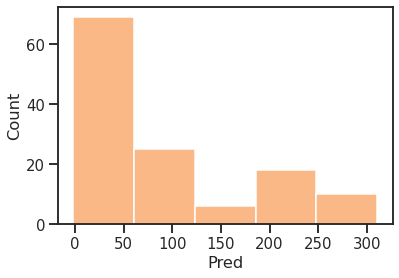

In [ ]:
# To visualize the distribution of data-driven predictions
sns.histplot(other_vars_constant['Pred'],bins=5)

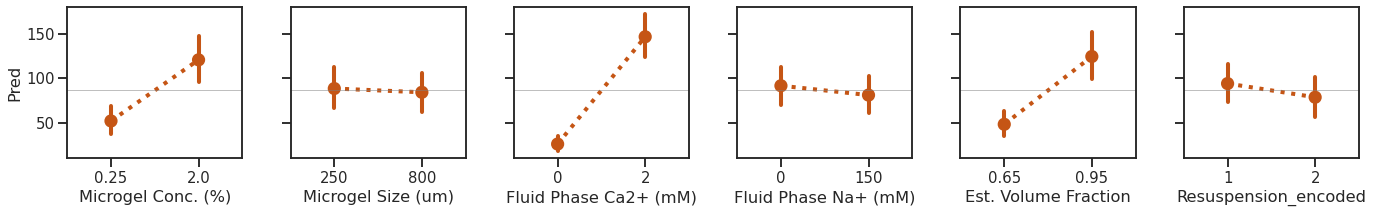

In [ ]:
# Define the columns you want to plot 
vars_to_iterate = X.columns

# Define the number of rows and columns 
rows=1;cols=len(vars_to_iterate)
fig,ax=plt.subplots(rows,cols,figsize=(cols*3.25,rows*3.25),sharey=True)

color = sns.color_palette(palette='Oranges_d',n_colors=4)[2]

i=0
for variable in vars_to_iterate: 
  sns.pointplot(x=variable,y='Pred',data=other_vars_constant,ax=ax[i],ci=95,linestyles=':',color=color); 
  ax[i].axhline(other_vars_constant['Pred'].mean(),c='grey',alpha=0.5,linewidth=1); 
  i+=1
[ax[c].set_ylabel('') for c in range(1,cols)];
fig.tight_layout()

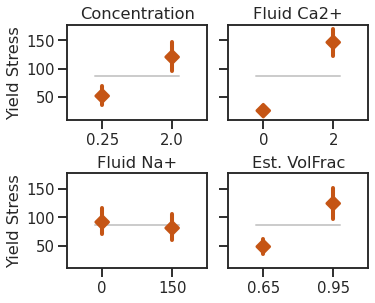

In [ ]:
rows=2;cols=2
fig,ax=plt.subplots(rows,cols,figsize=(cols*2.75,rows*2.25),sharey=True)

color = sns.color_palette(palette='Oranges_d',n_colors=4)[2]; linestyles=':'; join=False; linewidth=2; markers='D'; scale=0.9; errwidth=None; capsize=0.2

sns.pointplot(x='Microgel Conc. (%)',y='Pred',data=other_vars_constant,ax=ax[0,0],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[0,0].set_title('Concentration')

sns.pointplot(x='Fluid Phase Ca2+ (mM)',y='Pred',data=other_vars_constant,ax=ax[0,1],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[0,1].set_title('Fluid Ca2+'); 

sns.pointplot(x='Fluid Phase Na+ (mM)',y='Pred',data=other_vars_constant,ax=ax[1,0],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[1,0].set_title('Fluid Na+')

sns.pointplot(x='Est. Volume Fraction',y='Pred',data=other_vars_constant,ax=ax[1,1],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[1,1].set_title('Est. VolFrac'); 

#[sns.despine(ax=ax,top=True,right=True,left=True,trim=True) for ax in plt.gcf().axes] #[sns.despine(ax=ax,top=True,right=True,left=False,trim=False) for ax in plt.gcf().axes] #sns.despine(ax=ax[0,0],top=True,right=True,left=False); sns.despine(ax=ax[0,1],top=True,right=True,left=True); 
ax[0,0].set_ylabel("Yield Stress"); ax[1,0].set_ylabel("Yield Stress"); ax[0,1].set_ylabel(''); ax[1,1].set_ylabel(''); 
[ax.axhline(other_vars_constant['Pred'].mean(),xmin=0.2,xmax=0.8,c='grey',alpha=0.4,linewidth=2,linestyle='-',zorder=-1) for ax in plt.gcf().axes] #[ax.axhline(other_vars_constant['Pred_probability'].mean(),xmin=0,xmax=1,c='grey',alpha=0.5,linewidth=1,linestyle='-',zorder=-1) for ax in plt.gcf().axes]; 
#ax[0,0].set_yticks([1000,2000,3000]); #ax[0,0].set_yticklabels(['3kPa','2kPa','1kPa']); 
[ax.set_xlabel('') for ax in plt.gcf().axes]

fig.tight_layout(h_pad=0.5, w_pad=0.75)

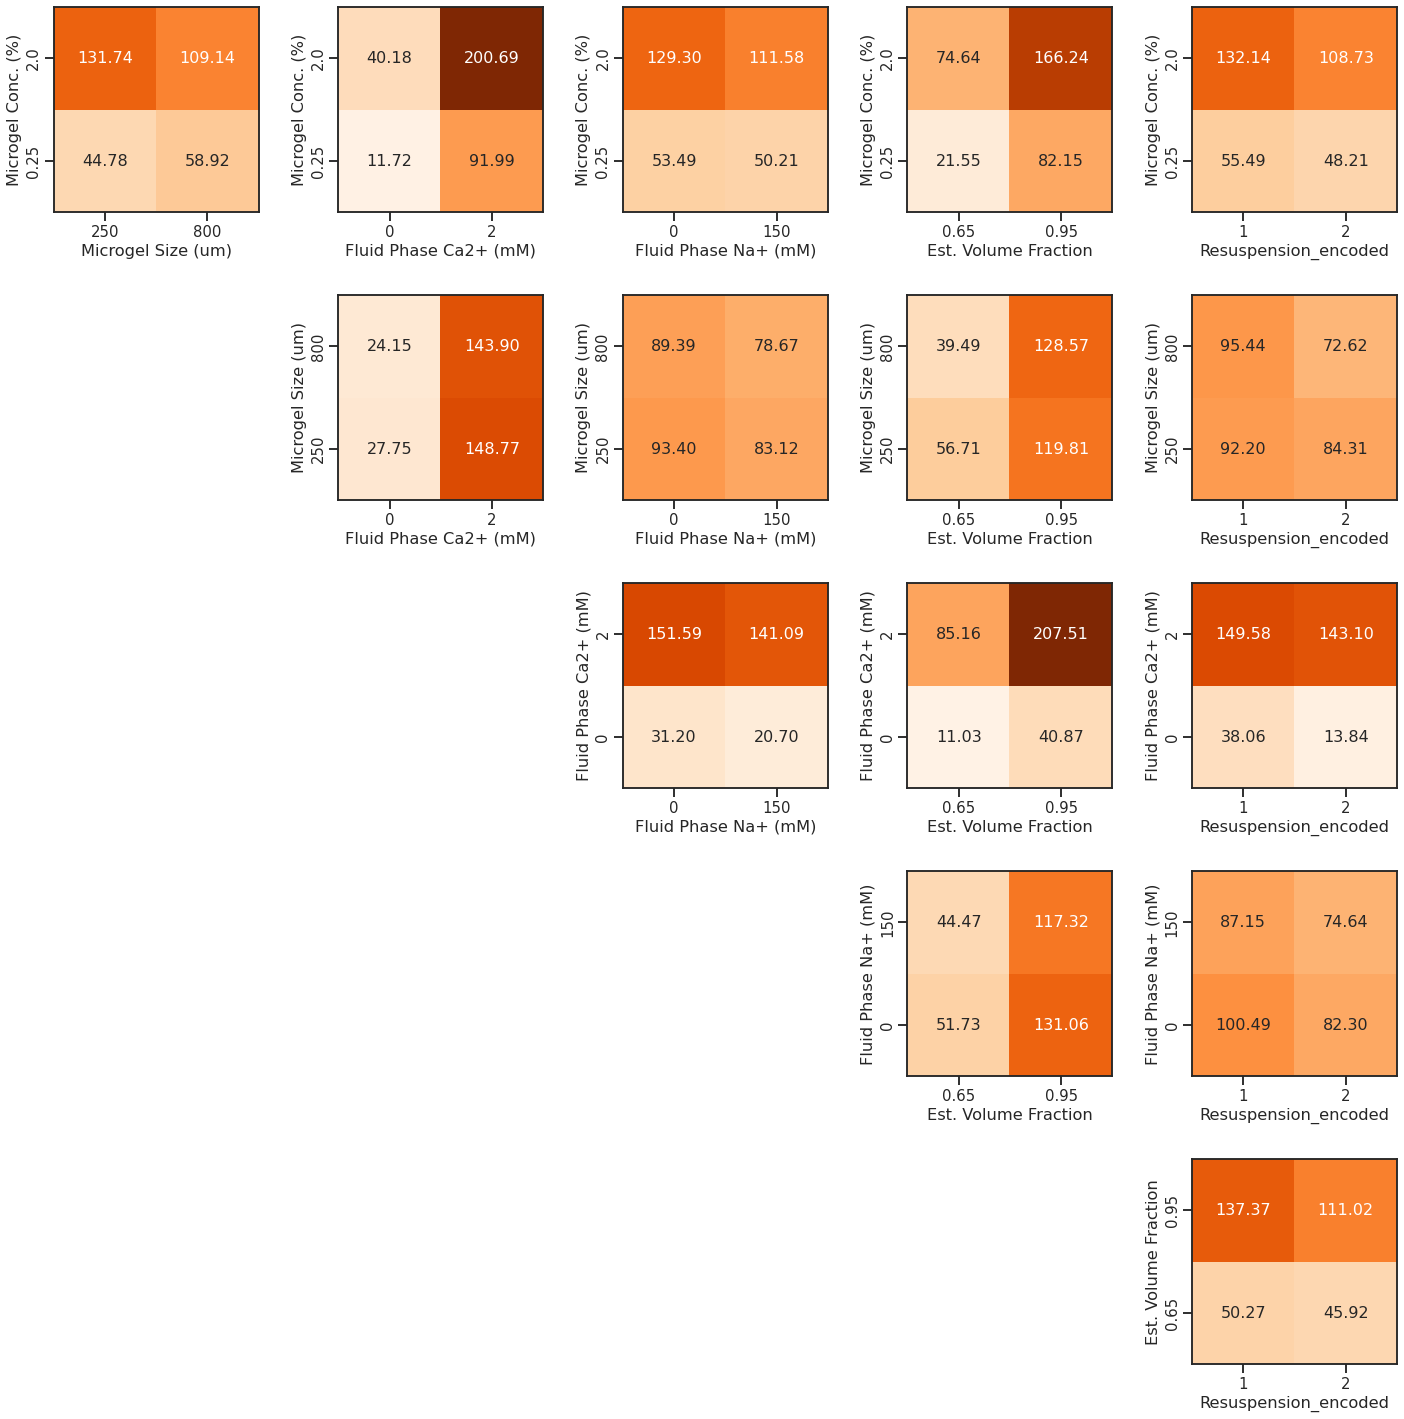

In [ ]:
# Define the columns you want to plot 
vars_to_iterate = X.columns

# Define the number of rows and columns 
rows=len(vars_to_iterate)-1;cols=len(vars_to_iterate)-1

# Define the figure 
fig,ax=plt.subplots(rows,cols,figsize=(cols*4, rows*4)); plt.subplots_adjust(wspace= 0.5, hspace= 0.5)

# Define heatmap attributes 
vmin=5;vmax=200;cmap='Oranges';annot=True;annot_size = 16;linewidth=0

# Initialize the row indexer, the column indexer, and an another variable to keep track of where the columns should start on a new row 
r,c,c_init=0,0,0

for pair in itertools.combinations(vars_to_iterate,2):   
  
  #print(r,c,c_init); print(pair)
  
  sns.heatmap(other_vars_constant.pivot_table(index=pair[0],columns=pair[1],values='Pred'),vmin=vmin,vmax=vmax,cmap=cmap,ax=ax[r,c],linewidths=linewidth,annot=annot,annot_kws={'size':annot_size},fmt=".2f",cbar=False)
  
  c+=1 # Mover over one column 

  if c == cols: # Check if you've reached the end of the row, in which case you need to move down by one and over by one 

    r+=1; c_init+=1; c=c_init # Move over one row, and then move over one column to maintain the diagonal structure of the matrix 

[ax.invert_yaxis() for ax in plt.gcf().axes] # Invert the y axis so the plot makes more sense

# Add the spines to each of the plots 
for ax in plt.gcf().axes: 
  for _, spine in ax.spines.items(): 
    spine.set_visible(True)

# Check if anything was actually added to the plot, and if there is no data you can delete the plot 
for ax in plt.gcf().axes: 
  if not ax.has_data(): 
    fig.delaxes(ax)

fig.tight_layout()

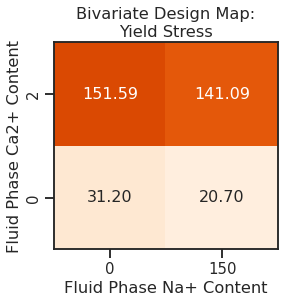

In [ ]:
rows=1;cols=1

fig,ax=plt.subplots(rows,cols,figsize=(cols*4.25, 4.5))

plt.subplots_adjust(wspace= 0.5, hspace= 0.5)

vmin=10;vmax=200;cmap='Oranges';annot=True;annot_size = 16;linewidth=0

sns.heatmap(other_vars_constant.pivot_table(index='Fluid Phase Ca2+ (mM)',columns='Fluid Phase Na+ (mM)',values='Pred'),vmin=vmin,vmax=vmax,cmap=cmap,ax=ax,linewidths=linewidth,annot=annot,annot_kws={'size':annot_size},fmt=".2f",cbar=False)

ax.invert_yaxis()

ax.set_xlabel('Fluid Phase Na+ Content'); ax.set_ylabel('Fluid Phase Ca2+ Content')

ax.set_title('Bivariate Design Map:\nYield Stress')

for ax in plt.gcf().axes:
  for _, spine in ax.spines.items():
      spine.set_visible(True)

fig.tight_layout()

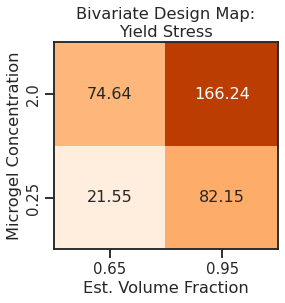

In [ ]:
rows=1;cols=1

fig,ax=plt.subplots(rows,cols,figsize=(cols*4.25, 4.5))

plt.subplots_adjust(wspace= 0.5, hspace= 0.5)

vmin=10;vmax=200;cmap='Oranges';annot=True;annot_size = 16;linewidth=0

sns.heatmap(other_vars_constant.pivot_table(index='Microgel Conc. (%)',columns='Est. Volume Fraction',values='Pred'),vmin=vmin,vmax=vmax,cmap=cmap,ax=ax,linewidths=linewidth,annot=annot,annot_kws={'size':annot_size},fmt=".2f",cbar=False)

ax.invert_yaxis()

ax.set_xlabel('Est. Volume Fraction'); ax.set_ylabel('Microgel Concentration')

ax.set_title('Bivariate Design Map:\nYield Stress')

for ax in plt.gcf().axes:
  for _, spine in ax.spines.items():
      spine.set_visible(True)

fig.tight_layout()

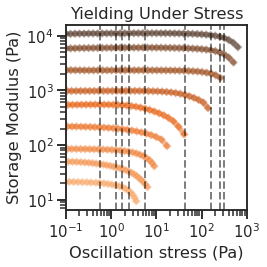

In [ ]:
for_plotting=test2.copy()

# Apply smoothing operations to the storage modulus (rolling windows, apply either median filter or mean filter to reduce high-frequency noise in the data)
for_plotting['Storage_med'] = for_plotting.groupby('Unique ID')['Storage modulus (Pa)'].rolling(window=5,center=True).median().reset_index(level=0, drop=True); for_plotting['Storage_mean'] = for_plotting.groupby('Unique ID')['Storage modulus (Pa)'].rolling(window=5,center=True).mean().reset_index(level=0, drop=True)

selected_ids = [17,24,72,61,58,75,85,36,63] 
example_data = for_plotting[for_plotting['Unique ID'].isin(selected_ids)]

# remove extra points from 61,58,82,36
example_data = example_data.drop(index=example_data[example_data['Unique ID']==61].apply(lambda x: x.iloc[-3:]).index)
example_data = example_data.drop(index=example_data[example_data['Unique ID']==58].apply(lambda x: x.iloc[-2:]).index)
example_data = example_data.drop(index=example_data[example_data['Unique ID']==75].apply(lambda x: x.iloc[-5:]).index)
example_data = example_data.drop(index=example_data[example_data['Unique ID']==36].apply(lambda x: x.iloc[-5:]).index)
# Ignore values below 1e-1 #example_data = example_data[example_data['Oscillation stress (Pa)'].ge(9e-2)]

linewidth=5; size=60; marker='D'
fig,ax=plt.subplots(1,1,figsize=(4,4))

sns.lineplot(x='Oscillation stress (Pa)',y='Storage_mean',data=example_data,ax=ax,hue='Storage_0',legend=False,palette=sns.color_palette(palette='Oranges_d',n_colors=example_data['Unique ID'].unique().shape[0]),linewidth=linewidth,alpha=0.5)
sns.scatterplot(x='Oscillation stress (Pa)',y='Storage_mean',data=example_data,hue='Storage_0',ax=ax,palette=sns.color_palette(palette='Oranges_d',n_colors=example_data['Unique ID'].unique().shape[0]),legend=False,size=size,marker=marker,alpha=0.5)

for id in selected_ids:
  ax.axvline(x=example_data[example_data['Unique ID']==id][y.name].iloc[0],linewidth=2,linestyle='--',color='black',alpha=0.5)

[ax.set_yscale('log') for ax in plt.gcf().axes]; [ax.set_xscale('log') for ax in plt.gcf().axes];# [ax.set_ylim(0.5e1,2e4) for ax in plt.gcf().axes]; [ax.set_xlim(2e-3,2e3) for ax in plt.gcf().axes]
ax.set_ylabel('Storage Modulus (Pa)'); ax.set_title('Yielding Under Stress') 
ax.set_xlim(1e-1,1e3); #ax.set_xlim(7e-2,1e3)
fig.tight_layout()

### Supplementary Evaluation

In [ ]:
# Basic information about X and y 
print('Matrix of X values:',X.shape[0],'observations and',X.shape[1],'features')
print('Feature names:',list(X.columns))
print('Vector of y values:',y.shape[0],'observations')
print('y name(s):',y.name)
print('Range of y values:',round(y.min(),1),'to',round(y.max(),1))
print('Mean of y values:',round(y.mean(),1))
print('Median of y values:',round(y.median(),1))
print('Standard deviation of y values:',round(y.std(),1))
print('Number of unique trials:',np.unique(groups).shape[0])

Matrix of X values: 101 observations and 6 features
Feature names: ['Microgel Conc. (%)', 'Microgel Size (um)', 'Fluid Phase Ca2+ (mM)', 'Fluid Phase Na+ (mM)', 'Est. Volume Fraction', 'Resuspension_encoded']
Vector of y values: 101 observations
y name(s): YS_breakdown_10
Range of y values: 0.1 to 318.4
Mean of y values: 36.0
Median of y values: 5.0
Standard deviation of y values: 69.2
Number of unique trials: 101


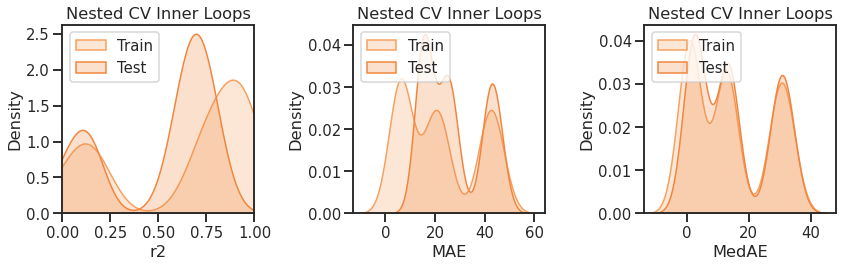

In [ ]:
# Plot the nested CV inner model evaluations 
fig,ax=plt.subplots(1,len(scoring_dict.keys()),figsize=(len(scoring_dict.keys())*4,4))

indexer=0
for scorer in scoring_dict.keys(): 
  sns.kdeplot(data=compiled_inner_crossval['mean_train_'+scorer],shade=True,label='Train',ax=ax[indexer])
  sns.kdeplot(data=compiled_inner_crossval['mean_test_'+scorer],shade=True,label='Test',ax=ax[indexer])
  ax[indexer].set_xlabel(scorer); ax[indexer].legend(loc='upper left'); ax[indexer].set_title('Nested CV Inner Loops')
  indexer+=1
ax[0].set_xlim(0,1)
fig.tight_layout()

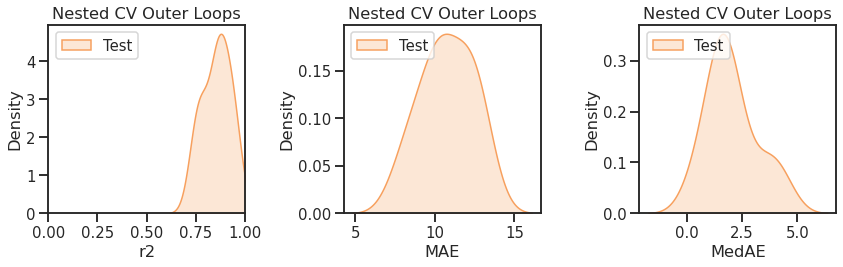

In [ ]:
# Plot the nested CV outer model evaluations
fig,ax=plt.subplots(1,len(scoring_dict.keys()),figsize=(len(scoring_dict.keys())*4,4))

indexer=0
for scorer in scoring_dict.keys(): 
  sns.kdeplot(data=compiled_best_models['outer_'+scorer],shade=True,label='Test',ax=ax[indexer])
  ax[indexer].set_xlabel(scorer); ax[indexer].legend(loc='upper left'); ax[indexer].set_title('Nested CV Outer Loops')
  indexer+=1
ax[0].set_xlim(0,1)
fig.tight_layout()

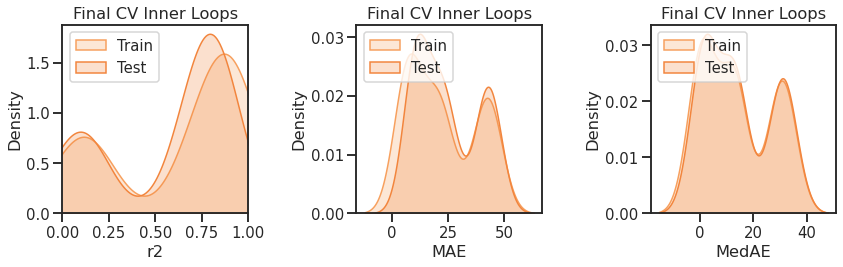

In [ ]:
# Plot the final CV inner model evaluations 
fig,ax=plt.subplots(1,len(scoring_dict.keys()),figsize=(len(scoring_dict.keys())*4,4))

indexer=0
for scorer in scoring_dict.keys(): 
  sns.kdeplot(data=final_search_results['mean_train_'+scorer],shade=True,label='Train',ax=ax[indexer])
  sns.kdeplot(data=final_search_results['mean_test_'+scorer],shade=True,label='Test',ax=ax[indexer])
  ax[indexer].set_xlabel(scorer); ax[indexer].legend(loc='upper left'); ax[indexer].set_title('Final CV Inner Loops')
  indexer+=1
ax[0].set_xlim(0,1)
fig.tight_layout()

In [ ]:
# Compute the permutation feature importance 
from sklearn.inspection import permutation_importance

level_0 = []; level_00 = []
for key in selected.keys(): 
  perm_imp = permutation_importance(selected[key],X,y,n_repeats=10,random_state=1,n_jobs=-1) # Compute the permutation feature importances and store the results 
  perm_imp_raw = pd.DataFrame(data=perm_imp.importances, index=X.columns) # Raw perm feat imp values for each var
  perm_imp_means = pd.DataFrame({'Var_names': X.columns,'PI_mean': perm_imp.importances_mean,'PI_std': perm_imp.importances_std}) # Mean and std feat imp for each var
  level_0.append(perm_imp_means); level_00.append(perm_imp_raw)

# Combine all of the results into a multi-index 
pi_means = pd.concat(level_0,keys=selected.keys()); pi_raw = pd.concat(level_00,keys=selected.keys())

# Melt the dataframe and rename the columns (makes it easier for plotting)
pi_raw_melt = pd.melt(pi_raw.reset_index(),id_vars=['level_0','level_1'],value_vars=pi_raw.columns).drop(columns='variable').rename(columns={'level_0':'Model','level_1':'variable','value':'Permutation Feature Importance'})

# Sort the feature importance (avereged between the two models) so that they are plotted from highest (top) to lowest (bottom) on the graph 
sorted_by_mean = pi_raw_melt.groupby('variable').mean().sort_values(by='Permutation Feature Importance',ascending=False).reset_index().rename(columns={'Permutation Feature Importance':'Avg PF Importance'})

pi_raw_melt_full = pd.merge(sorted_by_mean,pi_raw_melt,on='variable'); pi_raw_melt = pd.merge(sorted_by_mean.iloc[:6],pi_raw_melt,on='variable')

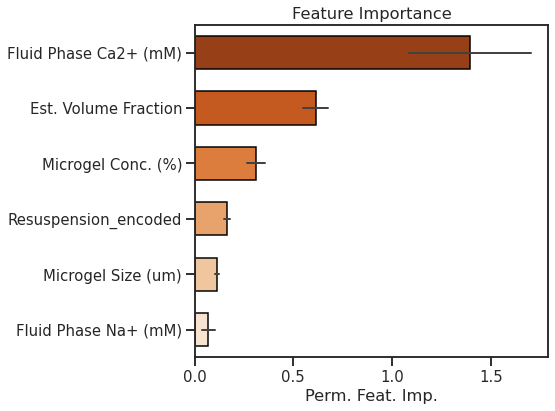

In [ ]:
fig = plt.figure(figsize=(8, 6))

plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

rows=1;cols=1

# Plot the permutation feature importance (bar plots for each variable - averaged) 

sub1 = fig.add_subplot(rows,cols,1) 

sns.barplot(y='variable',x='Permutation Feature Importance',data=pi_raw_melt_full,ax=sub1,edgecolor='k',errwidth=2,palette=sns.color_palette(palette='Oranges_r'),alpha=1)

sub1.set_title('Feature Importance'); sub1.set_ylabel(''); sub1.set_xlabel('Perm. Feat. Imp.'); sub1.set_xlim(xmin=0)

def change_width_y(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height(); diff = current_width - new_value

        patch.set_height(new_value) # change the bar width

        patch.set_y(patch.get_y() + diff * .5) # recenter the bar
change_width_y(sub1, .6)

fig.tight_layout()

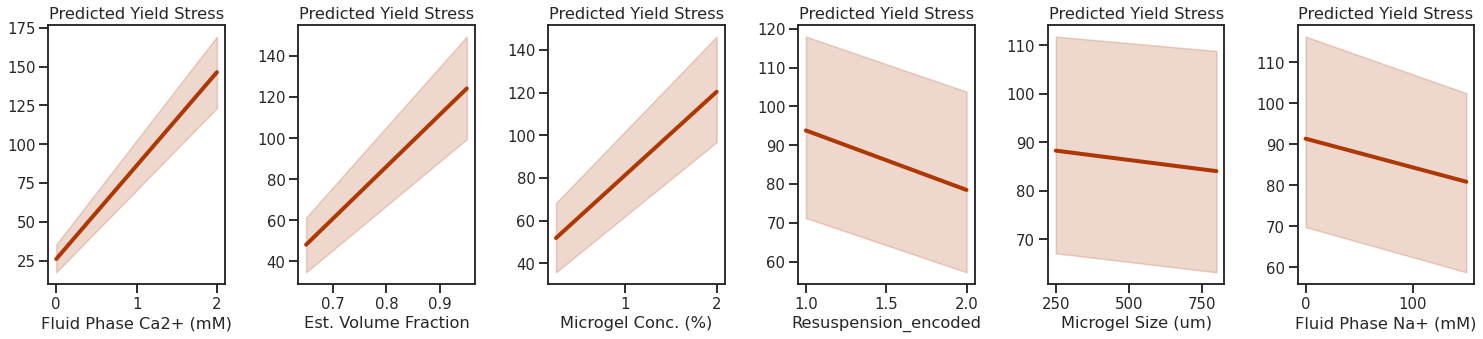

In [ ]:
# Plot the predicted values (given the n-dimensional cartesian product of unique feature values) along each possible feature axis 

yval = 'Pred'; title = 'Predicted Yield Stress'; format = '%.0f' # Modify these as needed 

from matplotlib.ticker import FormatStrFormatter

ordered_preds = pi_raw_melt_full.groupby('variable').mean().sort_values(by='Permutation Feature Importance',ascending=False).index.values

fig = plt.figure(figsize=(len(ordered_preds)*3.5, 5))

plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

rows=1;cols=len(ordered_preds) 

dict_for_pred_plots = {}
for i in range(len(ordered_preds)): 
  dict_for_pred_plots['sub'+str(i)] = fig.add_subplot(rows,cols,i+1)
  sns.lineplot(x=ordered_preds[i],y=yval,data=other_vars_constant,ax=dict_for_pred_plots['sub'+str(i)],linewidth=4,color=sns.color_palette(palette='Oranges_r')[0],)
  dict_for_pred_plots['sub'+str(i)].set_title(title); dict_for_pred_plots['sub'+str(i)].set_ylabel('');
  dict_for_pred_plots['sub'+str(i)].yaxis.set_major_formatter(FormatStrFormatter(format))

fig.tight_layout()

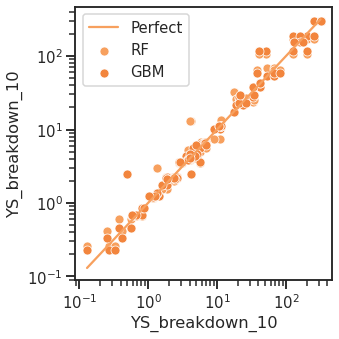

In [ ]:
fig,ax=plt.subplots(figsize=(5,5))

sns.lineplot(x=y,y=y,label='Perfect')
sns.scatterplot(x=y,y=rf.predict(X),label='RF')
sns.scatterplot(x=y,y=gbm.predict(X),label='GBM')
#sns.lineplot(x=[0,1000],y=[np.mean(y),np.mean(y)],label='Average')
[ax.set_yscale('log') for ax in plt.gcf().axes]; [ax.set_xscale('log') for ax in plt.gcf().axes]
fig.tight_layout()

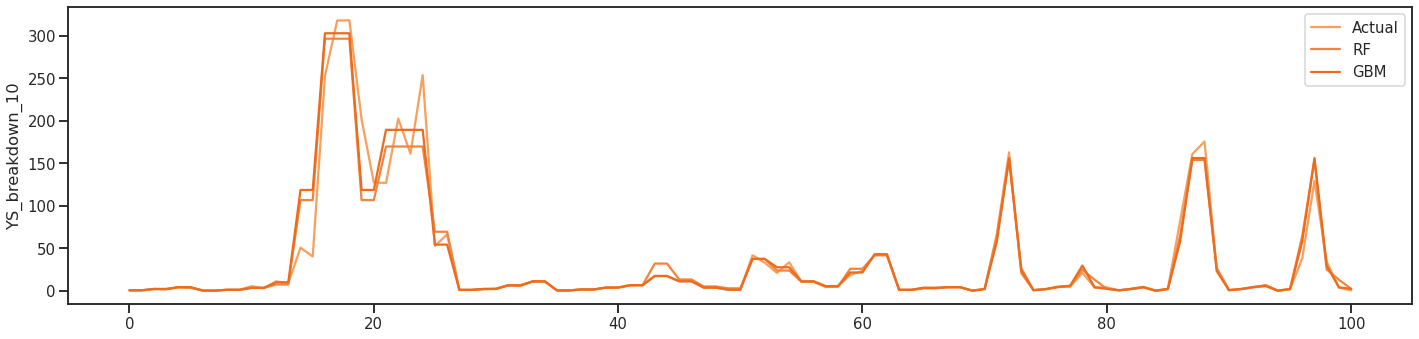

In [ ]:
fig,ax=plt.subplots(figsize=(20,5))
sns.lineplot(x=np.arange(len(y)),y=y,ax=ax,label='Actual')
sns.lineplot(x=np.arange(len(y)),y=rf.predict(X),ax=ax,label='RF')
sns.lineplot(x=np.arange(len(y)),y=gbm.predict(X),ax=ax,label='GBM')
fig.tight_layout()